In [1]:
from datasets import (
    load_from_disk,
    Dataset,
    concatenate_datasets
)
import pandas as pd
from transformers import (
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    DefaultDataCollator,
)
from tqdm.notebook import tqdm
import torch

# tokenizer 불러오기

In [2]:
MODEL_NAME="klue/roberta-large"
tokenizer=AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer

BertTokenizerFast(name_or_path='klue/roberta-large', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [3]:
tokenizer.mask_token, tokenizer.mask_token_id

('[MASK]', 4)

# dataset 가져와서 answer masking

In [4]:
dataset=load_from_disk("../../data/train_dataset/")
dataset=concatenate_datasets([dataset['train'],dataset['validation']])
dataset=dataset.flatten()

dataset

Dataset({
    features: ['title', 'context', 'question', 'id', 'document_id', '__index_level_0__', 'answers.answer_start', 'answers.text'],
    num_rows: 4192
})

In [5]:
df=dataset.to_pandas()

df['answer_text']=df['answers.text'].apply(lambda x:x[0])
df['answer_text_start']=df['answers.answer_start'].apply(lambda x:x[0])
df=df.drop(columns=['answers.text', 'answers.answer_start','__index_level_0__'])
df.head(2)

,title,context,question,id,document_id,answer_text,answer_text_start
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,18293,하원,235
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,51638,《경영의 실제》,212


In [6]:
from copy import copy

input_ids_list = []
token_start_index_list=[]
token_end_index_list=[]
salient_answer_list=[]
labels_list=[]
offset_list=[]
for i, row in tqdm(df.iterrows()):
    row['answer_text_end']=row['answer_text_start']+len(row['answer_text'])
    
    # masking answer
    encoded = tokenizer(row['context'], return_offsets_mapping=True,max_length=None)
    input_ids=encoded.pop('input_ids')
    labels=copy(input_ids)
    offsets = encoded.pop('offset_mapping') # token 인덱스 -> 원래 텍스트의 span

    # answer_start가 포함된 token의 index를 찾기
    token_start_index = 0
    while offsets[token_start_index][0] <= row['answer_text_start'] and \
        row['answer_text_start'] >= offsets[token_start_index][1]:
        token_start_index += 1

    # answer의 끝 index를 찾기
    token_end_index = token_start_index # 이전 start 인덱스에서부터 탐색
    while offsets[token_end_index][0] <= row['answer_text_end'] and \
        row['answer_text_end'] >= offsets[token_end_index][1]:
        token_end_index += 1

    # 찾아낸 answer들이 어떻게 tokenize되는지 보기 위해 저장
    salient_answer = tokenizer.decode(input_ids[token_start_index:token_end_index])
    # answer 부분 masking
    input_ids[token_start_index:token_end_index]=[tokenizer.mask_token_id]*(token_end_index-token_start_index)
    
    offset_list.append(offsets)
    token_start_index_list.append(token_start_index)
    token_end_index_list.append(token_end_index)
    salient_answer_list.append(salient_answer)
    input_ids_list.append(input_ids)
    labels_list.append(labels)

df['offsets']=offset_list
df['input_ids']=input_ids_list
df['token_start']=token_start_index_list
df['token_end']=token_end_index_list
df['salient_answer']=salient_answer_list
df['label_ids']=labels_list
df.head(2)

0it [00:00, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1022 > 512). Running this sequence through the model will result in indexing errors


,title,context,question,id,document_id,answer_text,answer_text_start,offsets,input_ids,token_start,token_end,salient_answer,label_ids
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,18293,하원,235,"[(0, 0), (0, 2), (3, 5), (5, 6), (7, 9), (10, ...","[0, 3666, 10346, 2252, 4013, 3666, 10450, 12, ...",123,124,하원,"[0, 3666, 10346, 2252, 4013, 3666, 10450, 12, ..."
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,51638,《경영의 실제》,212,"[(0, 0), (0, 1), (1, 3), (3, 4), (5, 8), (8, 9...","[0, 11, 5496, 2125, 11984, 11, 4013, 11, 6725,...",103,108,《 경영의 실제 》,"[0, 11, 5496, 2125, 11984, 11, 4013, 11, 6725,..."


In [7]:
df['isSame']=df['answer_text']==df['salient_answer']
df.head(2)

,title,context,question,id,document_id,answer_text,answer_text_start,offsets,input_ids,token_start,token_end,salient_answer,label_ids,isSame
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,18293,하원,235,"[(0, 0), (0, 2), (3, 5), (5, 6), (7, 9), (10, ...","[0, 3666, 10346, 2252, 4013, 3666, 10450, 12, ...",123,124,하원,"[0, 3666, 10346, 2252, 4013, 3666, 10450, 12, ...",True
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,51638,《경영의 실제》,212,"[(0, 0), (0, 1), (1, 3), (3, 4), (5, 8), (8, 9...","[0, 11, 5496, 2125, 11984, 11, 4013, 11, 6725,...",103,108,《 경영의 실제 》,"[0, 11, 5496, 2125, 11984, 11, 4013, 11, 6725,...",False


In [8]:
watch=df[df['isSame']==False][['answer_text','salient_answer']]

In [9]:
df[df['salient_answer']==""]

,title,context,question,id,document_id,answer_text,answer_text_start,offsets,input_ids,token_start,token_end,salient_answer,label_ids,isSame
254,신도 (장봉리),"노랑부리백로는 동부아시아의 온대, 우수리, 만주, 중국 동부, 한국 등지에서 주로 ...",섬의 꼭대기 부근에서 노랑부리백로와 공존하는 새는?,mrc-0-002958,28483,괭이갈매기,572,"[(0, 0), (0, 2), (2, 4), (4, 5), (5, 6), (6, 7...","[0, 18805, 18442, 2353, 2200, 2259, 6369, 1657...",304,304,,"[0, 18805, 18442, 2353, 2200, 2259, 6369, 1657...",False
342,휴먼센타이패드,카트먼이 다른 학생들은 다 가지고 있는 아이패드가 없지만 있는 척하다가 없다는 사실...,카일의 입과 항문이 연결된 사람은 어느 나라 사람인가?,mrc-1-001793,43615,일본,751,"[(0, 0), (0, 2), (2, 3), (3, 4), (5, 7), (8, 1...","[0, 15252, 2615, 2052, 3656, 3767, 2031, 2073,...",374,374,,"[0, 15252, 2615, 2052, 3656, 3767, 2031, 2073,...",False
717,세미놀 전쟁,"1818년 3월, 잭슨은 스콧 요새에 군대를 집결시켰다. 이 군대는 800명의 미연...",잘못을 인정하지 않고 반발한 인물은 누구인가?,mrc-0-000331,27774,아버스놋,1280,"[(0, 0), (0, 3), (3, 4), (4, 5), (6, 7), (7, 8...","[0, 15236, 2196, 2440, 23, 2429, 16, 16871, 20...",665,665,,"[0, 15236, 2196, 2440, 23, 2429, 16, 16871, 20...",False
1133,첼시 FC,첼시의 홈 유니폼은 파란색을 바탕으로 한다. 그러나 창단 초기의 홈 유니폼은 지금과...,토미 도허티의 지도 아래 첼시 선수들은 무슨 색 양말을 신게 되었는가?,mrc-1-000846,9844,하얀,237,"[(0, 0), (0, 2), (2, 3), (4, 5), (6, 9), (9, 1...","[0, 15088, 2079, 1930, 11300, 2073, 18280, 206...",122,122,,"[0, 15088, 2079, 1930, 11300, 2073, 18280, 206...",False
1188,마쿠라노소시,≪전쟁론≫ 이전에 전쟁 이론은 대부분 전략 및 전술 중심의 테마로 구성되었으나 ≪전...,현대 사회에서 전쟁의 궁극적인 목적으로 보는 것은?,mrc-0-002681,20507,정치,625,"[(0, 0), (0, 1), (1, 3), (3, 4), (4, 5), (6, 8...","[0, 133, 23249, 2570, 3572, 4176, 2170, 4175, ...",316,316,,"[0, 133, 23249, 2570, 3572, 4176, 2170, 4175, ...",False
1517,클레오파트라 3세 필로메토르 소테이라,기원전 142년 퓌스콘은 클레오파트라 2세를 버리고 클레오파트라 3세와 결혼했다. ...,클레오파트라 3세가 후계자를 지명할 수 있도록 유언한 사람은?,mrc-0-000492,25561,퓌스콘,210,"[(0, 0), (0, 3), (4, 7), (7, 8), (9, 13), (14,...","[0, 11561, 17205, 2440, 3, 12906, 2168, 2160, ...",115,115,,"[0, 11561, 17205, 2440, 3, 12906, 2168, 2160, ...",False
1684,소드 해변,"프랑스 공방전 이후, 영국 총리 윈스턴 처칠은 유럽 대륙과 나치 독일이 점령한 국가...",영국이 오버로드 작전을 수행할 시점에 캉은 어느 나라의 지배를 받고 있었나?,mrc-0-002896,37253,독일,721,"[(0, 0), (0, 3), (4, 6), (6, 7), (8, 10), (10,...","[0, 4510, 8722, 2165, 3719, 16, 4353, 4866, 14...",355,355,,"[0, 4510, 8722, 2165, 3719, 16, 4353, 4866, 14...",False
2116,열마디개미속,"열마디개미속의 개미들은 탁 트인 곳에 둥지를 만들며, 주식은 어린 식물, 씨앗, 그...",Fire ant의 침에 있는 성분은 무엇인가?,mrc-1-000953,23880,솔레놉신,179,"[(0, 0), (0, 1), (1, 3), (3, 4), (4, 5), (5, 6...","[0, 1432, 6295, 2019, 2044, 2354, 2079, 12646,...",98,98,,"[0, 1432, 6295, 2019, 2044, 2354, 2079, 12646,...",False
3127,클래리티,CLARITY 영상을 적용하는 과정은 조직 샘플로 시작한다. 다음으로 거의 모든 원...,세포 성분과 아크릴 아마이드의 결합을 위해 첨가되는 것은?,mrc-1-000762,43997,열,350,"[(0, 0), (0, 1), (1, 3), (3, 5), (5, 6), (6, 7...","[0, 39, 21072, 13607, 2081, 2214, 4729, 2069, ...",180,180,,"[0, 39, 21072, 13607, 2081, 2214, 4729, 2069, ...",False
3381,우르술라,성녀 우르술라와 그녀를 따른 처녀들에 관한 전설은 10세기에 기록된 성인전에서 유래...,훈족이 교황을 만나고 돌아가던 순례자들을 공격한 곳은?,mrc-0-003174,11058,쾰른,489,"[(0, 0), (0, 1), (1, 2), (3, 5), (5, 6), (6, 7...","[0, 1268, 2306, 26447, 2072, 2181, 2522, 3821,...",259,259,,"[0, 1268, 2306, 26447, 2072, 2181, 2522, 3821,...",False


# temporal expression

In [10]:
import re
for i in re.finditer(r'기원전 [0-9]+년',"기원전 123년 그리고 기원전 12년도"):
    print(i.span())

(0, 8)
(13, 20)


In [11]:
temporal_patterns=[
    r'(\d{1,4}년\s*)?\d{1,2}월\s*(\d{1,2}일)?',
    r'(기원전|BC)?\s*[0-9]+\s*(년|세기)',
    r'\d+\s*(개)?월',
    r'\d+일',
    r'[0-9]+\s*시간',
]

In [12]:
import re
temporal_span_list=[]
for i,row in df.iterrows():
    temporal_spans=[]
    for t_pattern in temporal_patterns:
        temporal_spans.extend([match.span() for match in re.finditer(t_pattern,row['context'])])
    temporal_span_list.append(temporal_spans)

df['temporal_span']=temporal_span_list

In [13]:
df.columns

Index(['title', 'context', 'question', 'id', 'document_id', 'answer_text',
       'answer_text_start', 'offsets', 'input_ids', 'token_start', 'token_end',
       'salient_answer', 'label_ids', 'isSame', 'temporal_span'],
      dtype='object')

In [14]:
for i, row in tqdm(df.iterrows()):
    for span in row['temporal_span']:
        # answer_start가 포함된 token의 index를 찾기
        token_start_index = 0
        while row['offsets'][token_start_index][0] <= span[0] and \
            span[0] >= row['offsets'][token_start_index][1]:
            token_start_index += 1

        # answer의 끝 index를 찾기
        token_end_index = token_start_index # 이전 start 인덱스에서부터 탐색
        while row['offsets'][token_end_index][0] <= span[1] and \
            span[1] >= row['offsets'][token_end_index][1]:
            token_end_index += 1

        # answer 부분 masking
        row['input_ids'][token_start_index:token_end_index]=[tokenizer.mask_token_id]*(token_end_index-token_start_index)

0it [00:00, ?it/s]

In [15]:
from collections import Counter
mask_num_list=[]
for i,row in df.iterrows():
    mask_num=Counter(row['input_ids'])[tokenizer.mask_token_id]
    mask_num_list.append(mask_num)
df['mask_num']=mask_num_list

(array([  5., 247., 262., 291., 208., 192., 197., 157., 164., 161., 176.,
        134., 110., 118., 119., 117., 115.,  84.,  93.,  78.,  91.,  78.,
         64.,  61.,  70.,  62.,  60.,  55.,  51.,  41.,  40.,  47.,  51.,
         30.,  32.,  28.,  33.,  22.,  20.,  23.,  21.,  18.,  20.,  20.,
         12.,  15.,  12.,   9.,   8.,   4.,   4.,   9.,   7.,   5.,   8.,
          3.,   2.,   3.,   3.,   1.,   2.,   3.,   2.,   4.,   2.,   0.,
          0.,   1.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.

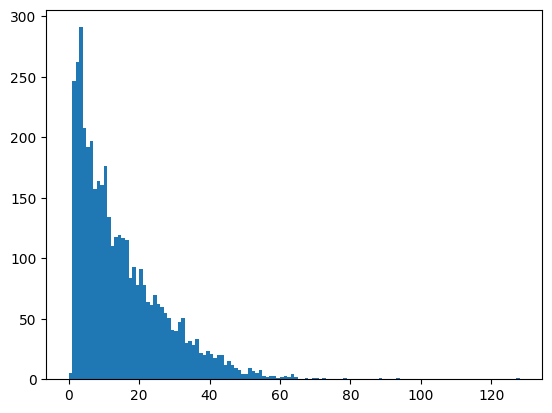

In [16]:
import matplotlib.pyplot as plt
plt.hist(df['mask_num'],bins=128,range=(0,128))

In [17]:
df.head()

,title,context,question,id,document_id,answer_text,answer_text_start,offsets,input_ids,token_start,token_end,salient_answer,label_ids,isSame,temporal_span,mask_num
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,18293,하원,235,"[(0, 0), (0, 2), (3, 5), (5, 6), (7, 9), (10, ...","[0, 3666, 10346, 2252, 4013, 3666, 10450, 12, ...",123,124,하원,"[0, 3666, 10346, 2252, 4013, 3666, 10450, 12, ...",True,"[(123, 126), (129, 132), (473, 476)]",7
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,51638,《경영의 실제》,212,"[(0, 0), (0, 1), (1, 3), (3, 4), (5, 8), (8, 9...","[0, 11, 5496, 2125, 11984, 11, 4013, 11, 6725,...",103,108,《 경영의 실제 》,"[0, 11, 5496, 2125, 11984, 11, 4013, 11, 6725,...",False,"[(43, 49), (194, 200), (336, 341), (402, 407),...",15
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,5028,백성,510,"[(0, 0), (0, 2), (2, 3), (3, 4), (5, 7), (7, 8...","[0, 23814, 2021, 2259, 4021, 2897, 1937, 2207,...",278,279,백성,"[0, 23814, 2021, 2259, 4021, 2897, 1937, 2207,...",True,"[(468, 474), (477, 481)]",6
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,34146,중국,625,"[(0, 0), (0, 2), (2, 3), (4, 6), (6, 7), (8, 1...","[0, 14506, 2069, 8081, 2015, 3627, 4506, 2075,...",355,356,중국,"[0, 14506, 2069, 8081, 2015, 3627, 4506, 2075,...",True,"[(645, 649)]",3
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,47334,4개,30,"[(0, 0), (0, 2), (2, 3), (3, 5), (5, 6), (6, 7...","[0, 5165, 2104, 4622, 2042, 2266, 2133, 27135,...",19,21,4개,"[0, 5165, 2104, 4622, 2042, 2266, 2133, 27135,...",True,"[(332, 337)]",4


In [18]:
len(df[df['input_ids'].apply(len)==df['label_ids'].apply(len)])

4192

In [19]:
masked_dataset=Dataset.from_pandas(df[['input_ids','label_ids']])
masked_dataset

Dataset({
    features: ['input_ids', 'label_ids'],
    num_rows: 4192
})

In [47]:
block_size = 512

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    return result

In [48]:
lm_dataset = masked_dataset.map(group_texts, batched=True, num_proc=4)
lm_dataset

Map (num_proc=4):   0%|          | 0/4192 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'label_ids'],
    num_rows: 4068
})

In [49]:
lm_dataset=lm_dataset.train_test_split(0.2)
lm_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'label_ids'],
        num_rows: 3254
    })
    test: Dataset({
        features: ['input_ids', 'label_ids'],
        num_rows: 814
    })
})

In [56]:
def mlm_data_collator(features: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    batch = {}
    
    batch["input_ids"] = torch.stack([torch.LongTensor(feature["input_ids"]) for feature in features])
    batch["labels"] = torch.stack([torch.LongTensor(feature["label_ids"]) for feature in features])

    return batch

In [52]:
from transformers import AutoModelForMaskedLM, Trainer, TrainingArguments
model=AutoModelForMaskedLM.from_pretrained(MODEL_NAME)

In [59]:

training_args=TrainingArguments(
    output_dir="klue-roberta-large-tsm",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    evaluation_strategy='epoch',
    num_train_epochs=10,
    learning_rate=2e-5,
    push_to_hub=True,
    push_to_hub_model_id='klue-roberta-large-tsm',
    hub_strategy='every_save',
    report_to=None
)

trainer=Trainer(
    model=model,
    args=training_args,
    data_collator=mlm_data_collator,
    train_dataset=lm_dataset['train'],
    eval_dataset=lm_dataset['test'],
)

trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/training_args.py:1524: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/transformers/training_args.py:1543: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case tjddn0402/klue-roberta-large-tsm).
  warnings.warn(
/opt/ml/level2_nlp_mrc-nlp-03/code/pretraining/klue-roberta-large-tsm is already a clone of https://huggingface.co/tjddn0402/klue-roberta-large-tsm. Make sure you pull the latest changes with `repo.git_pull()`.
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_depre

Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 500.00 MiB (GPU 0; 31.75 GiB total capacity; 21.06 GiB already allocated; 104.50 MiB free; 21.09 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [60]:
torch.cuda.empty_cache()